## Specific conductance, dissolved load, and calcite saturation state

Specific conductance (SpC) is an indicator of the dissolved load in the water. At our site, we expect most of that dissolved load to be from carbonate minerals. However, it could also indicate polution. In that case, other ions, such as Chloride (which we measured) could also be high.

#### Questions

- How does dissolved load change from one part of the system to another?
- Is there any evidence that these differences are a function of polution, or could it just be differences in dissolved carbonate?
- Is the water undersaturated, saturated, or supersaturated with respect to calcite?
- Does evolution of SpC along the sinking stream show any evidence of precipitation or dissolution, or can the changes in SpC be explained purely by mixing of waters from the springs and stream?

#### Read in water quality data

In [13]:
# Read in the water quality data from the spreadsheet
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# Make a boxplot of SpC measurements categorized by type of site
# (spring, epikarst, stream, well)



### SpC and pollution

In [ ]:
# To examine whether there is any relationship between SpC and
# pollution, make a scatter plot of SpC vs Chloride.



### Calcite Saturation

To examine calcite saturation, we will use functions from a Python package called *Olm*, which was written to conduct basic water chemistry analysis in karst settings. First we need to install this package (if you haven't already done so). We can install using the following command.

In [1]:
!pip install olm-karst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 701.6 kB/s eta 0:00:00 kB/s eta 0:00:01:01


To see more about what *Olm* can do, check out the Github repository here:

https://github.com/CovingtonResearchGroup/olm/tree/master

Or the example tutorials here:

https://github.com/CovingtonResearchGroup/olm-examples

We will use *Olm* here to estimate the saturation state of the water with respect to calcite (the main component of limestone). These calcualtions assume that the chemistry is dominated by ions in the $H_2O - CO_2 - CaCO_3$ system. If we have a substantial component from other ions (for example from pollution), then these calculations will be inaccurate.

The first step is to estimate the dissolved Calcium concentration from our SpC values. This could be done using a global relationship which is provided in olm.general.CaFromCond(). However, we can do better, since we have a set of Ca concentrations and SpC measurements from Savoy.

In [27]:
# This csv contains SpC (uS/cm) and Ca (mg/L) values from water samples at Savoy.
savoy_chem = read_csv('data/savoy_chem.csv')
savoy_chem

# Note, the pH and temp data here are fabricated (all the same value).
# We will just use them to illustrate the method of saturation
# ratio calculation below.

,SpC,Ca,pH,T_C
0,223.0,40.6,7.8,15
1,221.0,40.1,7.8,15
2,147.0,25.4,7.8,15
3,181.0,31.6,7.8,15
4,162.0,27.6,7.8,15
...,...,...,...,...
83,340.0,55.2,7.8,15
84,170.0,24.0,7.8,15
85,170.0,24.8,7.8,15
86,147.0,23.2,7.8,15


Text(0, 0.5, 'Ca concentration (mg/L)')

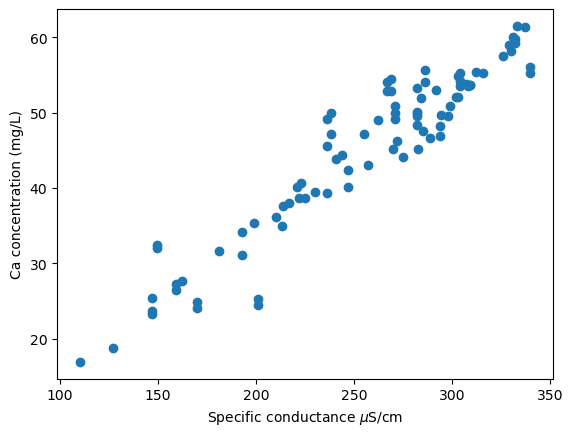

In [20]:
# Let's plot the relationship
plt.plot(savoy_chem['SpC'], savoy_chem['Ca'], 'o')
plt.xlabel('Specific conductance $\mu$S/cm')
plt.ylabel('Ca concentration (mg/L)')

You can see that there is a relatively good linear relationship between Ca and SpC. Therefore, we can use this relationship to estimate what Ca would be, just from our SpC measurements in the field. To do this, we need to fit a line.

In [21]:
from scipy.stats import linregress

slope, intercept, r, p, se = linregress(savoy_chem['SpC'], savoy_chem['Ca'])


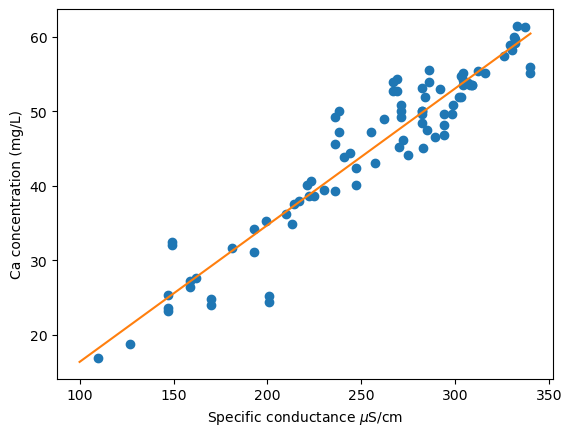

In [22]:
# We can plot this best fit on top of the data like this
plt.plot(savoy_chem['SpC'], savoy_chem['Ca'], 'o')
plt.xlabel('Specific conductance $\mu$S/cm')
plt.ylabel('Ca concentration (mg/L)')

# Create an array of SpC values to make our line, picking an appropriate range
SpC_model = np.linspace(100,340, 5) 
Ca_model = slope*SpC_model + intercept
plt.plot(SpC_model, Ca_model, '-')


In [25]:
# Now, we can use values of SpC, along with the slope and
# intercept derived above, to estimate Ca. Here we will 
# illustrate this with the values above. However, you should
# do this below with the SpC values you collected in the field.

Ca_mg_L = slope*savoy_chem.SpC + intercept

Once we have Ca, we can use *Olm* to do the hard work of estimating calcite saturation state. It can approximate the chemistry of a solution using Ca and pH using the process below.

In [26]:
# First, we need to convert Ca into mol/L.
from olm.general import mgL_to_molL

# We just have to provide the concentration and tell it which ion we have
Ca_mol_L = mgL_to_molL(Ca_mg_L, 'Ca')

In [28]:
# This is the function we use to calculation the properties
# of the solution.
from olm.calcite import solutionFrompHCaRelaxed

pH_obs = savoy_chem.pH # use our fabricated pH values as example
T_C_obs = savoy_chem.T_C # use our fabricated temp values as example

solutions = solutionFrompHCaRelaxed(Ca_mol_L, pH_obs, T_C=T_C_obs)




With *Olm*, many types of calculations can be done with 'solution' objects. Here we will calculate the equilibrium concentration of Ca with respect to calcite.

In [30]:
from olm.calcite import concCaEqFromSolution

#This estimates the equilibrium Ca concentration in mol/L
Ca_eq = concCaEqFromSolution(solutions)


One way to express saturation state is using the 'saturation ratio,' ${\rm R=Ca/Ca_{eq}}$. The solution is saturated if $R=1$, undersaturated if $R<1$, and supersaturated if $R>1$.

In [32]:
R = Ca_mol_L/Ca_eq
R

0     0.965076
1     0.959075
2     0.720650
3     0.834588
4     0.771992
        ...   
83    1.288876
84    0.798658
85    0.798658
86    0.720650
87    0.720650
Length: 88, dtype: float64

Text(0, 0.5, 'Number per bin')

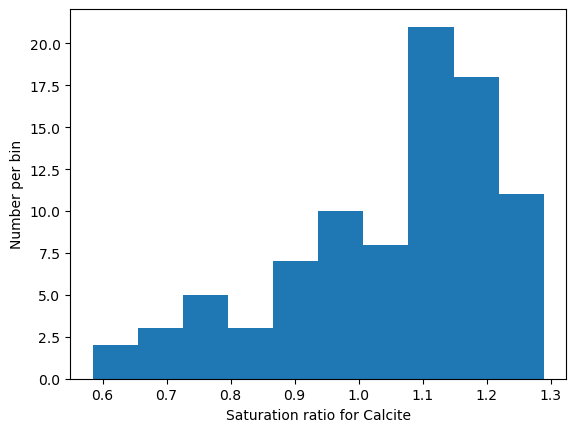

In [34]:
# One way to visualize this would be with a histogram, since we
# have lots of values.

plt.hist(R)
plt.xlabel('Saturation ratio for Calcite')
plt.ylabel('Number per bin')

Now make similar calculations using your field data and the method demonstrated above. What is the saturation state at your field sites? In addition to a histogram, you might consider making a boxplot of saturation ratio at different types of sites.

We can make this adjustment using a function available in the *Olm* carbonate water chemistry package for Python. First we have to install it (if you haven't already done so). We can do this using the command below.

One of the critical considerations in analyzing conductivity data, is correction to specific conductance at 25 degrees Celcius. Since temperature also influences raw conductivity, we need to account for this effect by adjusting all measurements to equivalent SpC @ 25 C.

In [2]:
# The function we use for converting to SpC @ 25 C
# is called condTo25. We import it like this.
from olm.general import condTo25

## Long-term SpC records

In [ ]:
# There are long-term SpC records from Langle
# and Copperhead Springs in 'data/Langle.csv' and
# 'data/Copperhead.csv' 

# Read in these data and plot up the time series of
# SpC at Langle and Copperhead. You can use
# these longer records to get a bigger context for the
# SpC data you collected yesterday.

